<a href="https://colab.research.google.com/github/vsairam-uc/GenAI-and-LLM/blob/main/normalizing_flow_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp

## Parameters

In [2]:
COUPLING_DIM = 512
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 600

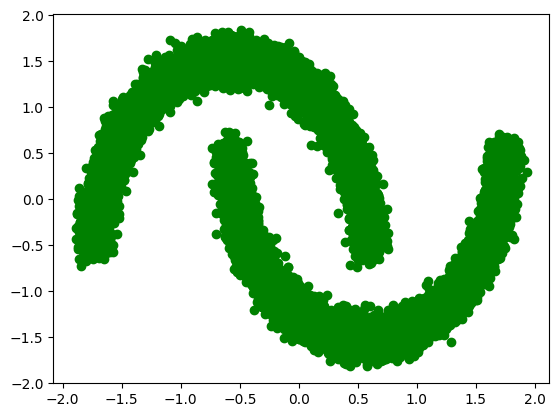

In [3]:
# Load the data
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

## Build the RealNVP network

In [4]:
# Custom Coupling Layer
class CouplingLayer(layers.Layer):
    def __init__(self, input_dim, coupling_dim, reg ):
        super(CouplingLayer, self).__init__()
        self.scale_net = tf.keras.Sequential([
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(input_dim, activation='tanh')  # Scale output
        ])
        self.translation_net = tf.keras.Sequential([
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(coupling_dim, activation='relu', kernel_regularizer=regularizers.l2(reg)),
            layers.Dense(input_dim)  # Translation output
        ])

    def call(self, inputs):
        x1, x2 = inputs , inputs
        scale = self.scale_net(x1)
        translation = self.translation_net(x1)
        return scale, translation

In [5]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            CouplingLayer(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

## Train the RealNVP network

In [6]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [7]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

In [8]:
!mkdir output

Epoch 1/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.6007
Saved to ./output/generated_img_000.png


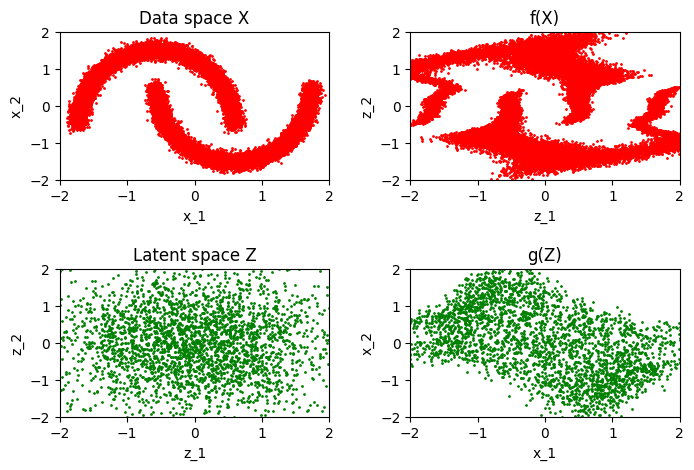

118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - loss: 2.5996
Epoch 2/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.2854
Epoch 3/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1132
Epoch 4/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0153
Epoch 5/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8924
Epoch 6/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7786
Epoch 7/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7642
Epoch 8/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7576
Epoch 9/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7586
Epoch 10/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7668
Epoch 11/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7480
Saved to ./output/generated_img_010.png


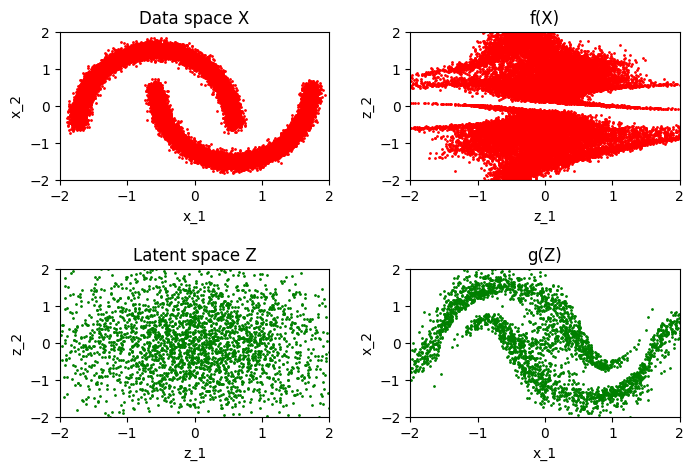

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7482
Epoch 12/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7753
Epoch 13/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7484
Epoch 14/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8067
Epoch 15/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7355
Epoch 16/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7534
Epoch 17/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7376
Epoch 18/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7391
Epoch 19/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7369
Epoch 20/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7211
Epoch 21/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7406
Saved to ./output/generated_img_020.png


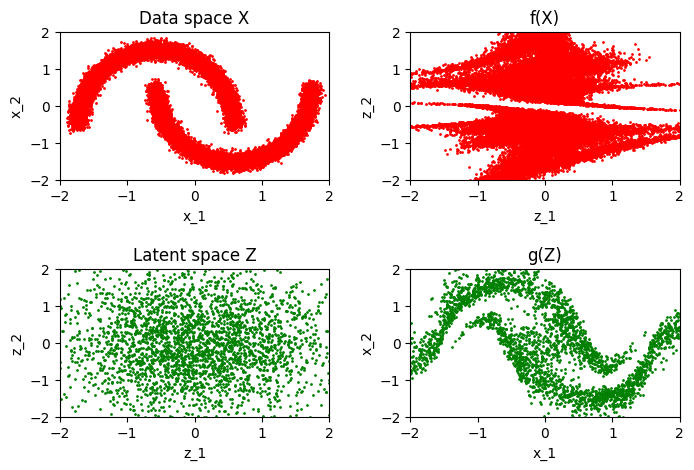

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7414
Epoch 22/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7500
Epoch 23/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7377
Epoch 24/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7403
Epoch 25/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7322
Epoch 26/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7439
Epoch 27/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7423
Epoch 28/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7365
Epoch 29/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7267
Epoch 30/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7303
Epoch 31/600
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7326
Saved to ./output/generated_img_030.png


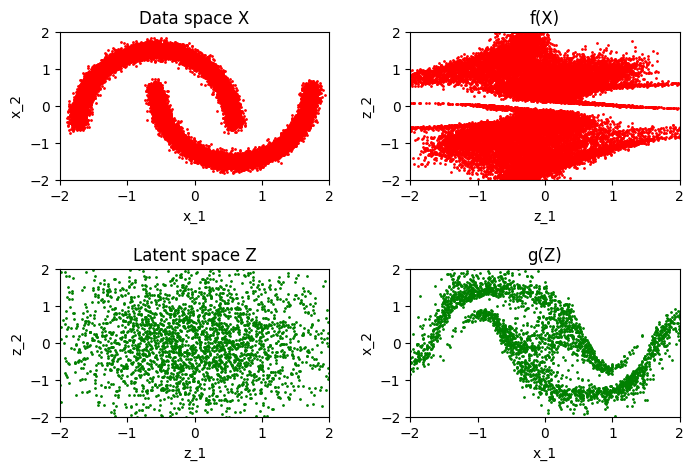

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7325
Epoch 32/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7367
Epoch 33/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7278
Epoch 34/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7468
Epoch 35/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7316
Epoch 36/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7394
Epoch 37/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7527
Epoch 38/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7252
Epoch 39/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7251
Epoch 40/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7174
Epoch 41/600
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7327
Saved to ./output/generated_img_040.png


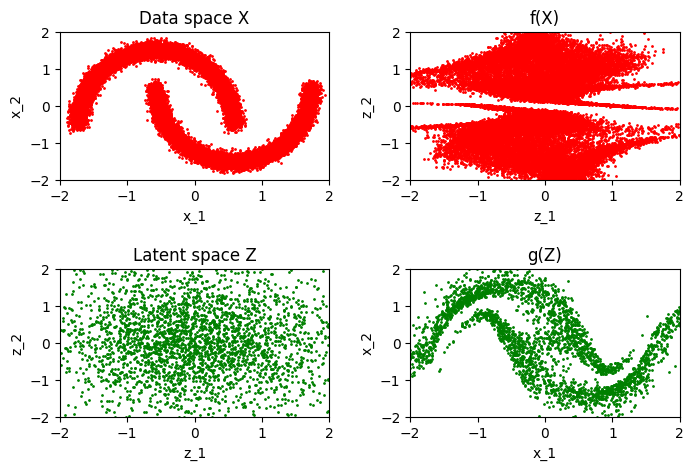

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7325
Epoch 42/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7285
Epoch 43/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7161
Epoch 44/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7254
Epoch 45/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7424
Epoch 46/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7304
Epoch 47/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7325
Epoch 48/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7136
Epoch 49/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7294
Epoch 50/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7176
Epoch 51/600
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7446
Saved to ./output/generated_img_050.png


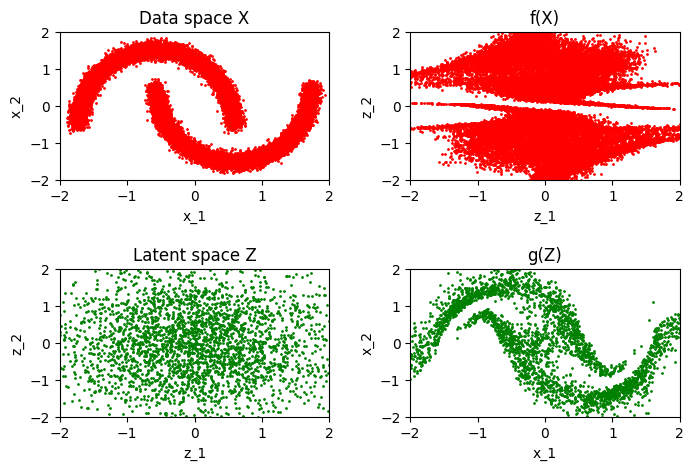

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.7437
Epoch 52/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.7173
Epoch 53/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7330
Epoch 54/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7285
Epoch 55/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7142
Epoch 56/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7289
Epoch 57/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7270
Epoch 58/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7243
Epoch 59/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7120
Epoch 60/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7240
Epoch 61/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7252
Saved to ./output/generated_img_060.png


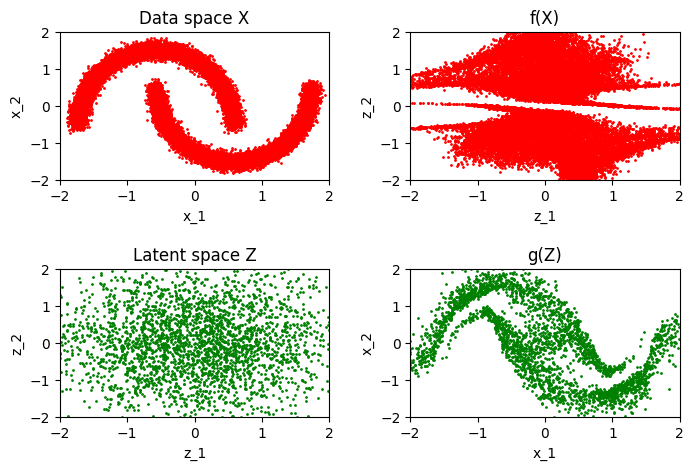

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.7251
Epoch 62/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7164
Epoch 63/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7219
Epoch 64/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7178
Epoch 65/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7242
Epoch 66/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7127
Epoch 67/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7232
Epoch 68/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7088
Epoch 69/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7118
Epoch 70/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7393
Epoch 71/600
113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7162
Saved to ./output/generated_img_070.png


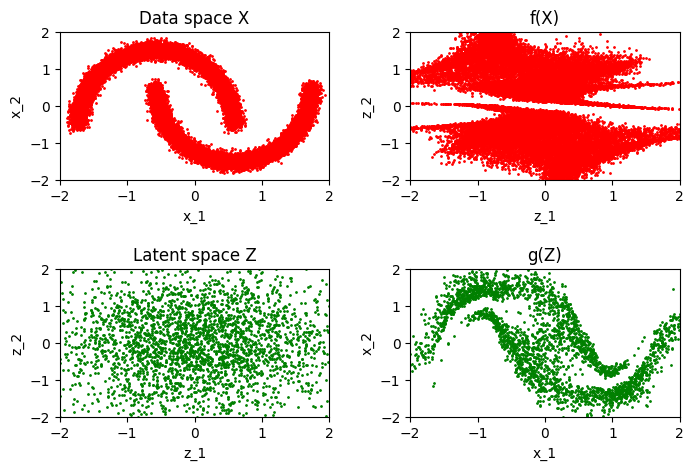

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7164
Epoch 72/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7379
Epoch 73/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7213
Epoch 74/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7088
Epoch 75/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7214
Epoch 76/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7727
Epoch 77/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7167
Epoch 78/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7240
Epoch 79/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7155
Epoch 80/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7129
Epoch 81/600
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7067
Saved to ./output/generated_img_080.png


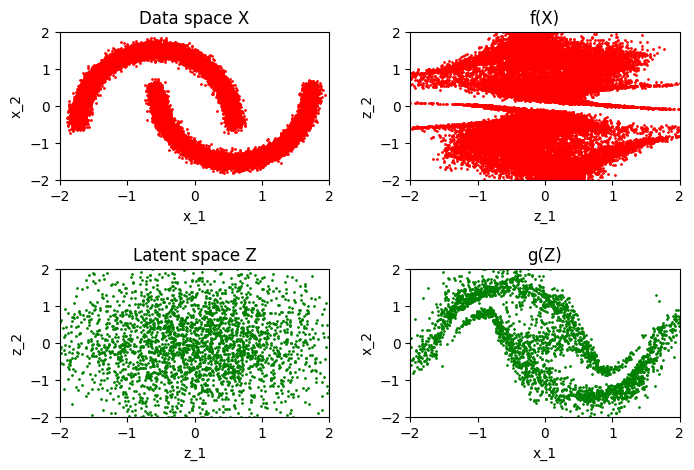

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.7071
Epoch 82/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7088
Epoch 83/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7135
Epoch 84/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7285
Epoch 85/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7104
Epoch 86/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7285
Epoch 87/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7174
Epoch 88/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7200
Epoch 89/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7162
Epoch 90/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7194
Epoch 91/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7063
Saved to ./output/generated_img_090.png


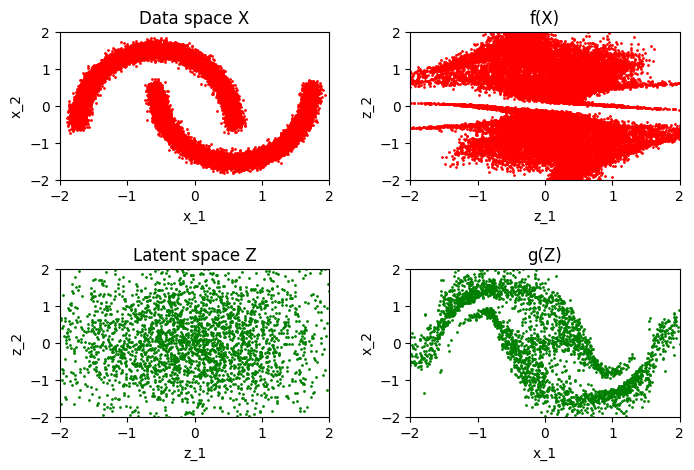

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7064
Epoch 92/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7175
Epoch 93/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7212
Epoch 94/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7035
Epoch 95/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7165
Epoch 96/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7000
Epoch 97/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7156
Epoch 98/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7037
Epoch 99/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7046
Epoch 100/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7190
Epoch 101/600
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7159
Saved to ./output/generated_img_100.png


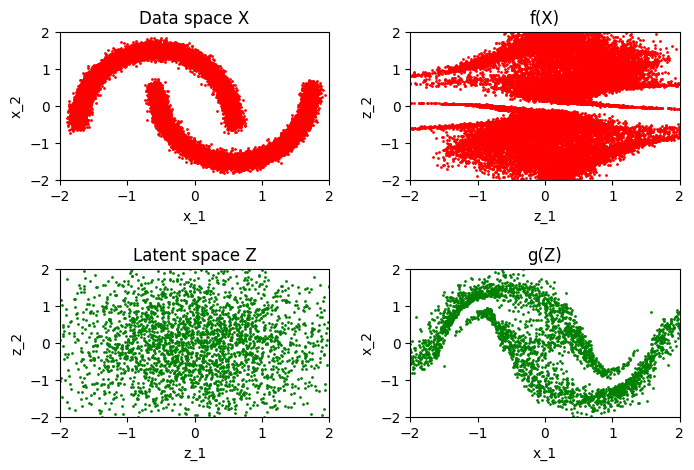

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7158
Epoch 102/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7164
Epoch 103/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7145
Epoch 104/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7145
Epoch 105/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7217
Epoch 106/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7072
Epoch 107/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7086
Epoch 108/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7236
Epoch 109/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7264
Epoch 110/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7232
Epoch 111/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7032
Saved to ./output/generated_img_110.png


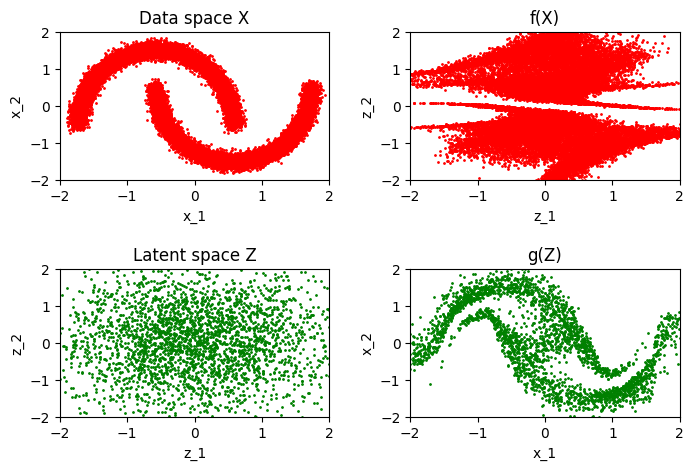

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7033
Epoch 112/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7086
Epoch 113/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7126
Epoch 114/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7033
Epoch 115/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7104
Epoch 116/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7206
Epoch 117/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7113
Epoch 118/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7186
Epoch 119/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7161
Epoch 120/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7152
Epoch 121/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7026
Saved to ./output/generated_img_120.png


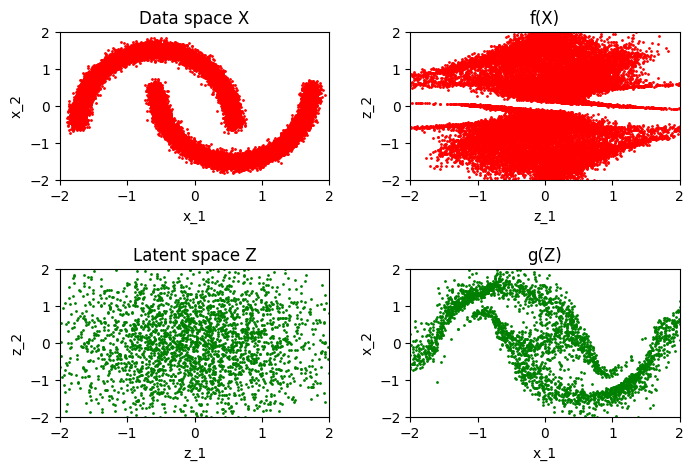

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7027
Epoch 122/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.7089
Epoch 123/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7193
Epoch 124/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7092
Epoch 125/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7056
Epoch 126/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7141
Epoch 127/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7109
Epoch 128/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7060
Epoch 129/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7317
Epoch 130/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7081
Epoch 131/600
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7161
Saved to ./output/generated_img_130.png


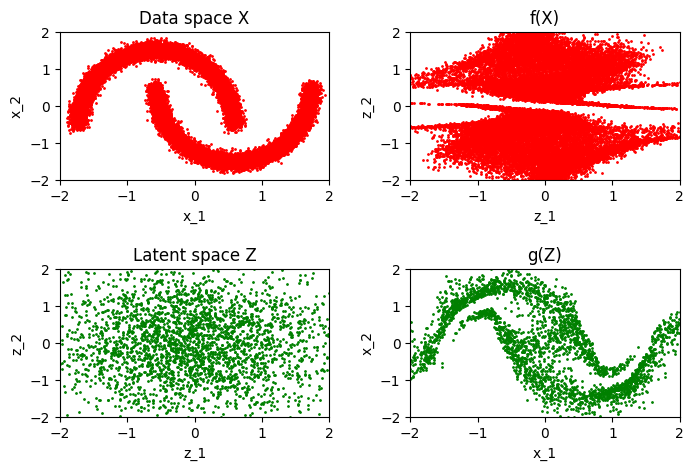

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7157
Epoch 132/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7031
Epoch 133/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7070
Epoch 134/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7218
Epoch 135/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7089
Epoch 136/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7166
Epoch 137/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7106
Epoch 138/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7240
Epoch 139/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7318
Epoch 140/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7101
Epoch 141/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7089
Saved to ./output/generated_img_140.png


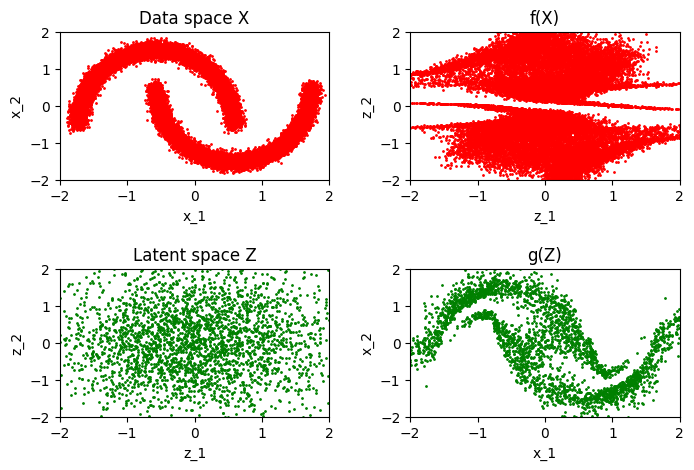

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7088
Epoch 142/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7078
Epoch 143/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7081
Epoch 144/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7101
Epoch 145/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7160
Epoch 146/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7110
Epoch 147/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6963
Epoch 148/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7036
Epoch 149/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7024
Epoch 150/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6983
Epoch 151/600
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6986
Saved to ./output/generated_img_150.png


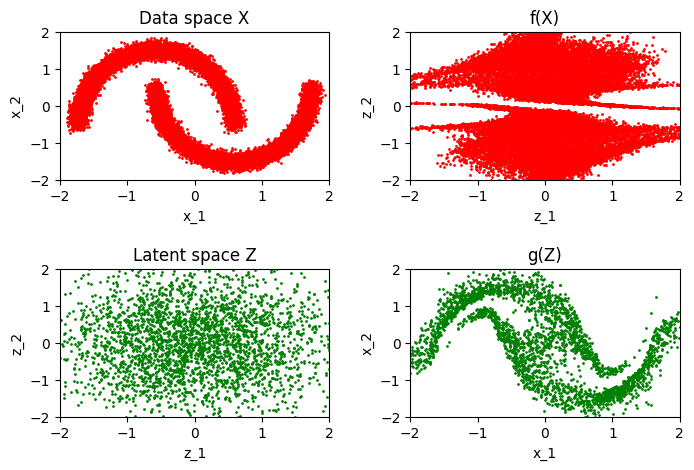

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.6988
Epoch 152/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7151
Epoch 153/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7093
Epoch 154/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7118
Epoch 155/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7074
Epoch 156/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7283
Epoch 157/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7171
Epoch 158/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7135
Epoch 159/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7040
Epoch 160/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7083
Epoch 161/600
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6983
Saved to ./output/generated_img_160.png


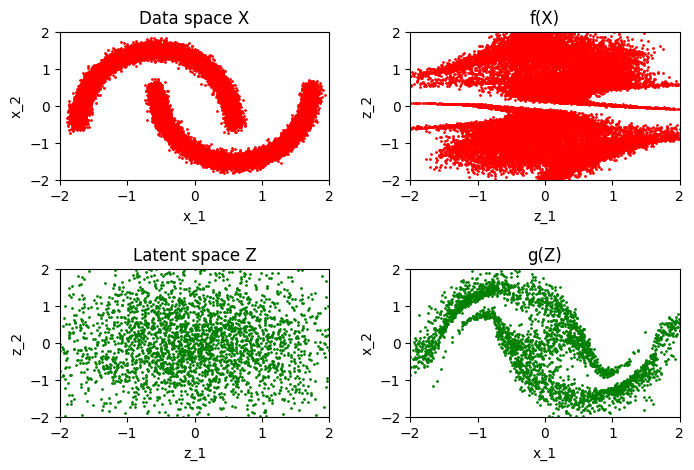

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6986
Epoch 162/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7234
Epoch 163/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6985
Epoch 164/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7076
Epoch 165/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7077
Epoch 166/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7036
Epoch 167/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7056
Epoch 168/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7042
Epoch 169/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6976
Epoch 170/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6975
Epoch 171/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7105
Saved to ./output/generated_img_170.png


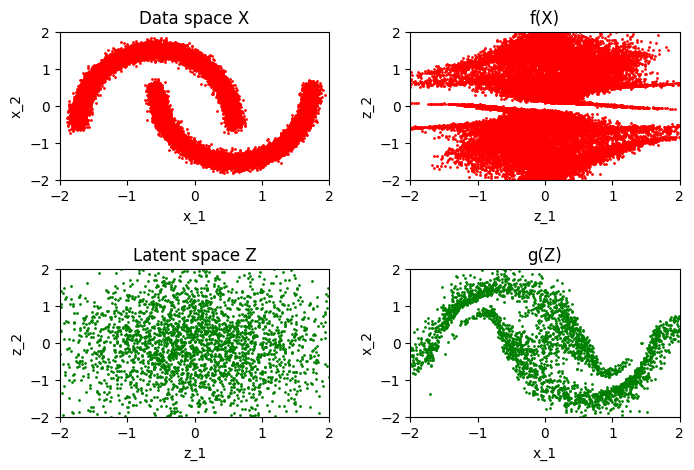

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7104
Epoch 172/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7013
Epoch 173/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7147
Epoch 174/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7094
Epoch 175/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7211
Epoch 176/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7121
Epoch 177/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7066
Epoch 178/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7121
Epoch 179/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7263
Epoch 180/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7077
Epoch 181/600
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7039
Saved to ./output/generated_img_180.png


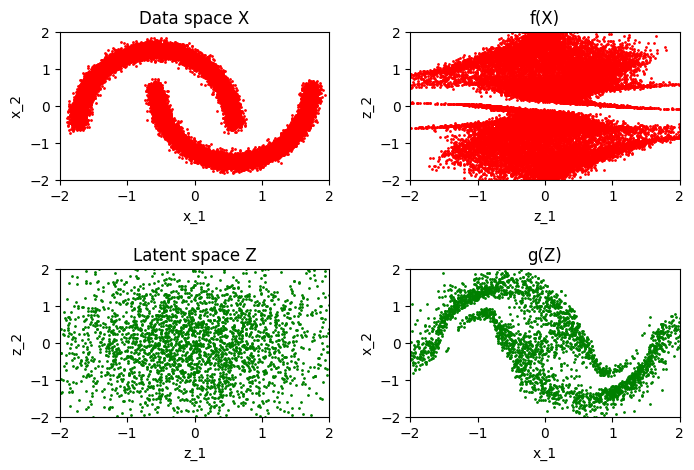

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7039
Epoch 182/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7153
Epoch 183/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7097
Epoch 184/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7105
Epoch 185/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7068
Epoch 186/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7062
Epoch 187/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7495
Epoch 188/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7027
Epoch 189/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7138
Epoch 190/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7019
Epoch 191/600
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7110
Saved to ./output/generated_img_190.png


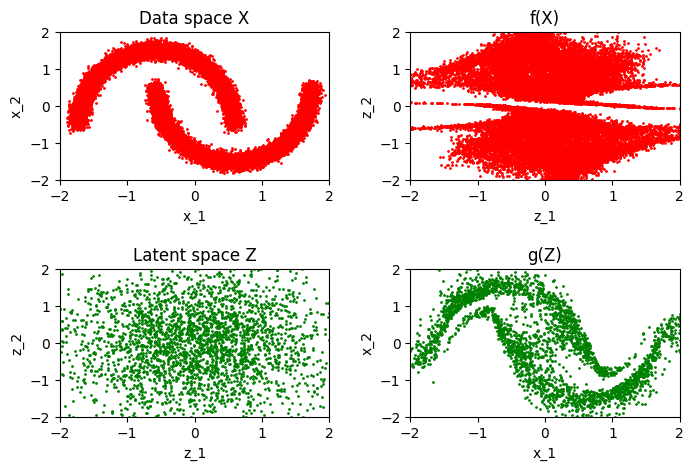

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7106
Epoch 192/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7076
Epoch 193/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7005
Epoch 194/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7189
Epoch 195/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7141
Epoch 196/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6980
Epoch 197/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7016
Epoch 198/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7327
Epoch 199/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6998
Epoch 200/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7287
Epoch 201/600
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7086
Saved to ./output/generated_img_200.png


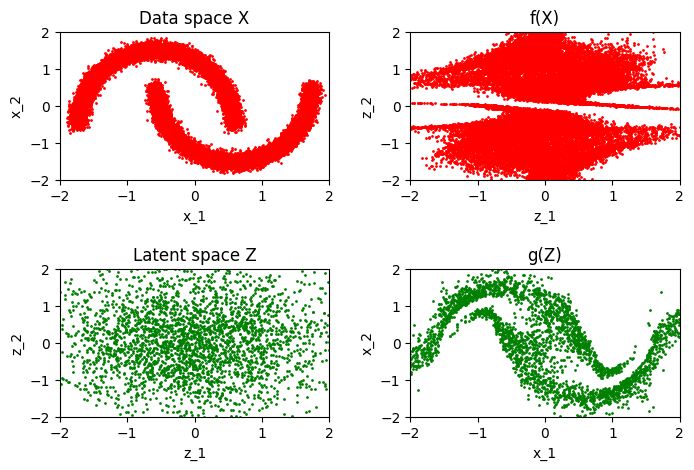

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7086
Epoch 202/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7038
Epoch 203/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6939
Epoch 204/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7005
Epoch 205/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7041
Epoch 206/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7115
Epoch 207/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7134
Epoch 208/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6991
Epoch 209/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7038
Epoch 210/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6996
Epoch 211/600
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6938
Saved to ./output/generated_img_210.png


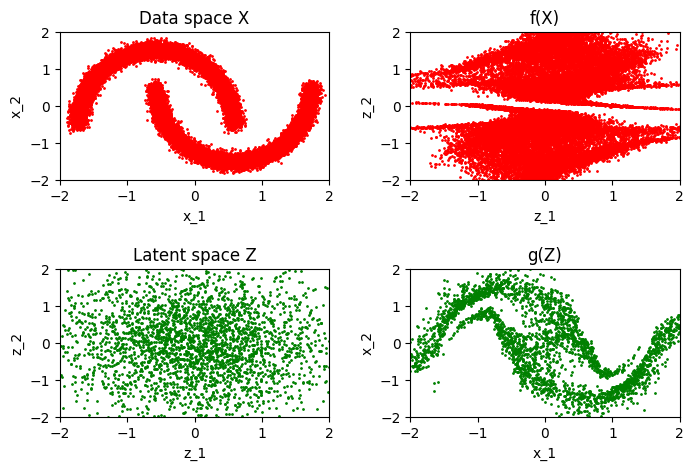

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.6941
Epoch 212/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6969
Epoch 213/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7057
Epoch 214/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7029
Epoch 215/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7054
Epoch 216/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7005
Epoch 217/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7054
Epoch 218/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6940
Epoch 219/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7046
Epoch 220/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6971
Epoch 221/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7033
Saved to ./output/generated_img_220.png


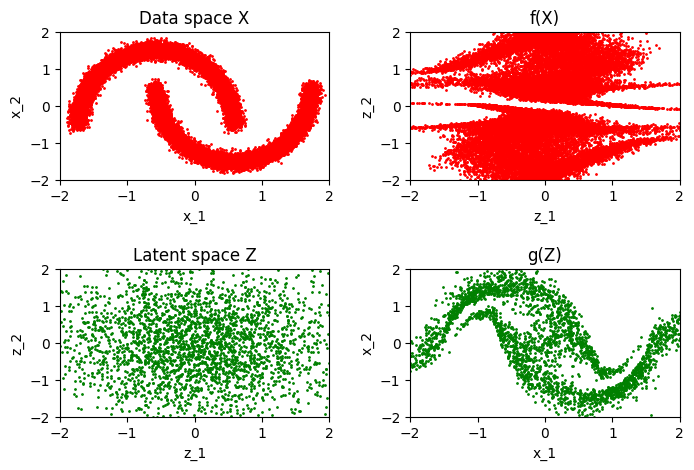

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7033
Epoch 222/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7078
Epoch 223/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7154
Epoch 224/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7025
Epoch 225/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7032
Epoch 226/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7093
Epoch 227/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7176
Epoch 228/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6976
Epoch 229/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7024
Epoch 230/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7028
Epoch 231/600
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7067
Saved to ./output/generated_img_230.png


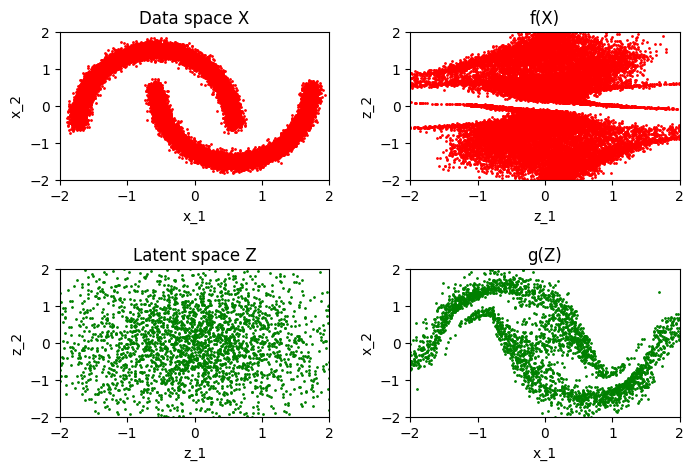

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7063
Epoch 232/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7050
Epoch 233/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6995
Epoch 234/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7139
Epoch 235/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6967
Epoch 236/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6969
Epoch 237/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7133
Epoch 238/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7198
Epoch 239/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7039
Epoch 240/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7046
Epoch 241/600
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6992
Saved to ./output/generated_img_240.png


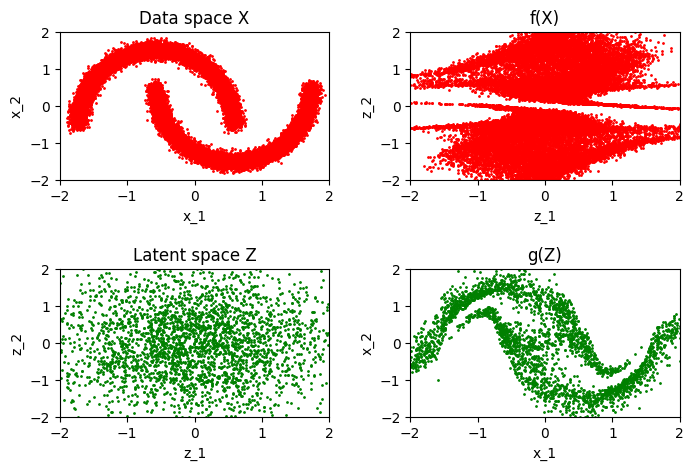

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.6994
Epoch 242/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7042
Epoch 243/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6965
Epoch 244/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7019
Epoch 245/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7158
Epoch 246/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7114
Epoch 247/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7054
Epoch 248/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7050
Epoch 249/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7107
Epoch 250/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7106
Epoch 251/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7098
Saved to ./output/generated_img_250.png


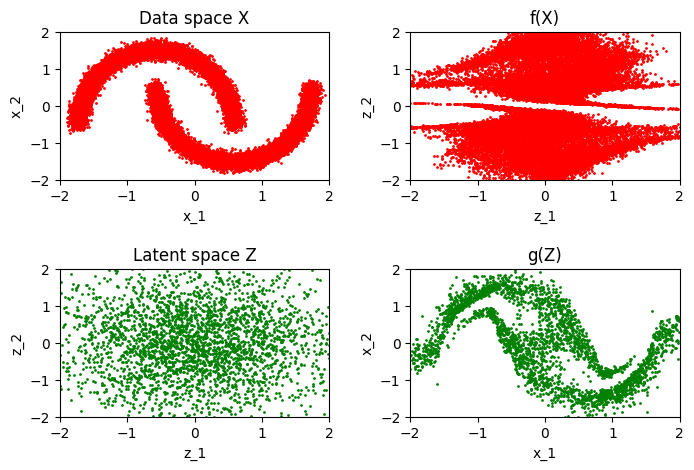

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7098
Epoch 252/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7006
Epoch 253/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6976
Epoch 254/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7054
Epoch 255/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7031
Epoch 256/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6929
Epoch 257/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7040
Epoch 258/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7073
Epoch 259/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7007
Epoch 260/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7033
Epoch 261/600
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6968
Saved to ./output/generated_img_260.png


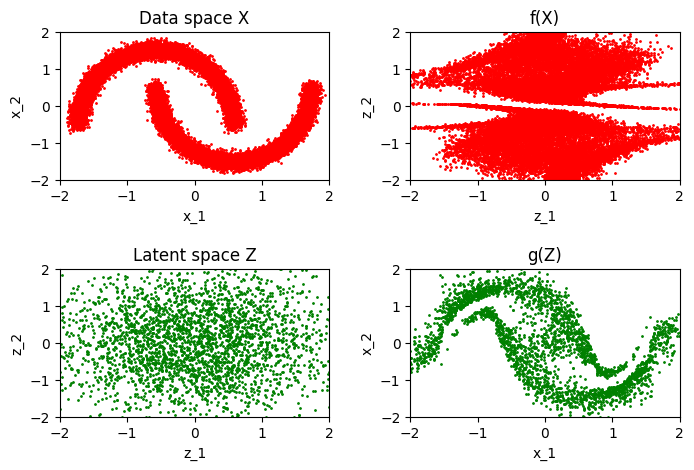

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.6969
Epoch 262/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6964
Epoch 263/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6966
Epoch 264/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7150
Epoch 265/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7018
Epoch 266/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7007
Epoch 267/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7099
Epoch 268/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7166
Epoch 269/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7009
Epoch 270/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7087
Epoch 271/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7076
Saved to ./output/generated_img_270.png


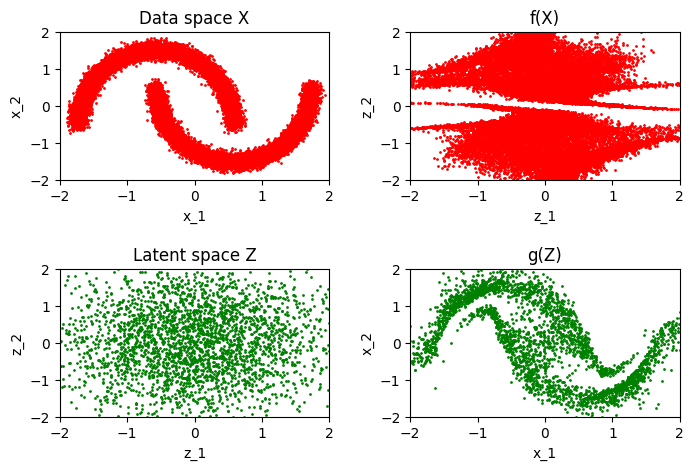

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.7076
Epoch 272/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6959
Epoch 273/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7017
Epoch 274/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7084
Epoch 275/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6968
Epoch 276/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6992
Epoch 277/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6889
Epoch 278/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7011
Epoch 279/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6948
Epoch 280/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7129
Epoch 281/600
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7130
Saved to ./output/generated_img_280.png


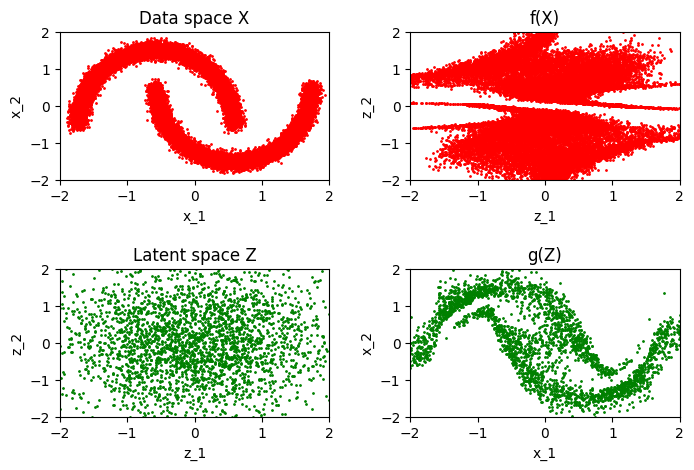

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.7129
Epoch 282/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7274
Epoch 283/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7231
Epoch 284/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6920
Epoch 285/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7061
Epoch 286/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6957
Epoch 287/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7037
Epoch 288/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6998
Epoch 289/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7016
Epoch 290/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7024
Epoch 291/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6942
Saved to ./output/generated_img_290.png


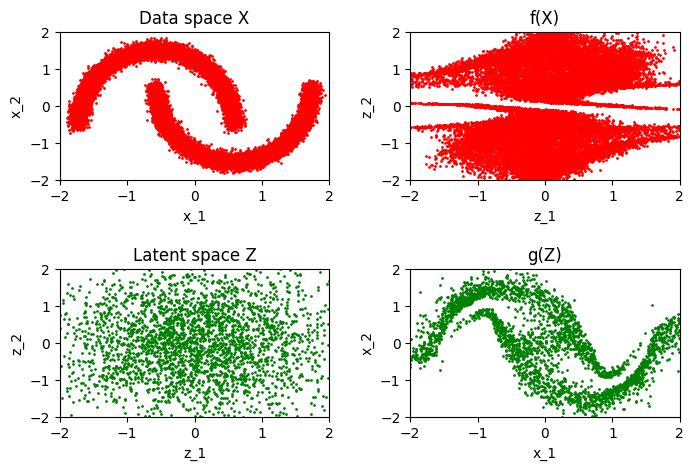

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6943
Epoch 292/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7060
Epoch 293/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7027
Epoch 294/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7006
Epoch 295/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7014
Epoch 296/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7385
Epoch 297/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7301
Epoch 298/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6941
Epoch 299/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7044
Epoch 300/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7013
Epoch 301/600
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7005
Saved to ./output/generated_img_300.png


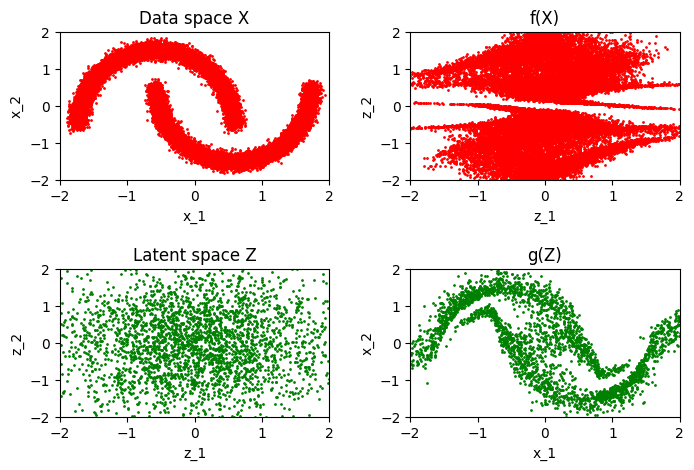

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7003
Epoch 302/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7040
Epoch 303/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7025
Epoch 304/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6937
Epoch 305/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6975
Epoch 306/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6982
Epoch 307/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6992
Epoch 308/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7085
Epoch 309/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6970
Epoch 310/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7001
Epoch 311/600
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6929
Saved to ./output/generated_img_310.png


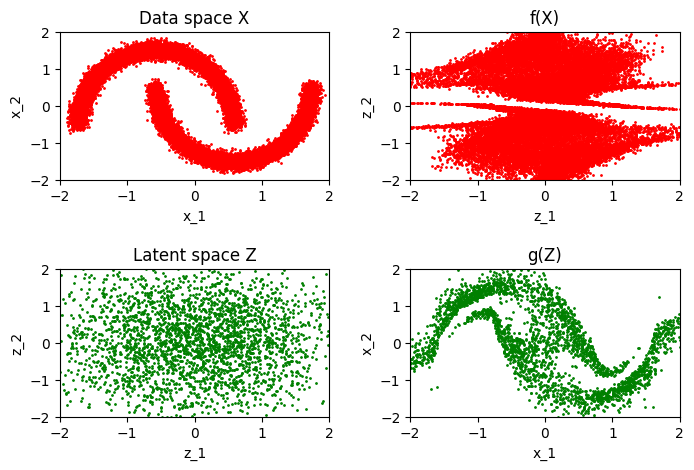

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.6934
Epoch 312/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7108
Epoch 313/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7000
Epoch 314/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6936
Epoch 315/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7041
Epoch 316/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7048
Epoch 317/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6898
Epoch 318/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6995
Epoch 319/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7011
Epoch 320/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7031
Epoch 321/600
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7000
Saved to ./output/generated_img_320.png


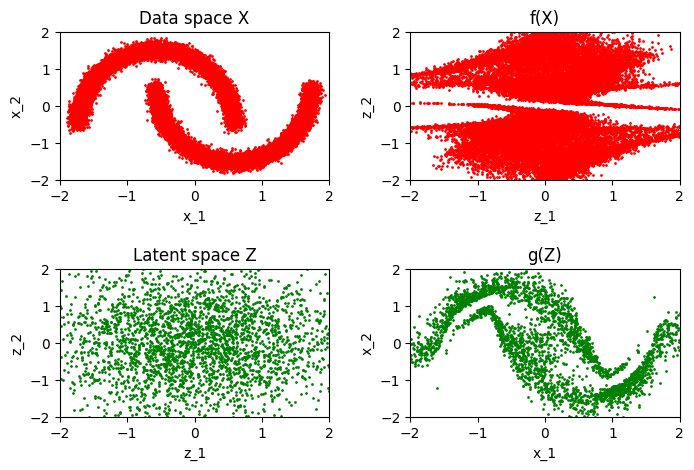

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.7000
Epoch 322/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7082
Epoch 323/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7016
Epoch 324/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7186
Epoch 325/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7074
Epoch 326/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6979
Epoch 327/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7026
Epoch 328/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7026
Epoch 329/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6959
Epoch 330/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6958
Epoch 331/600
113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6967
Saved to ./output/generated_img_330.png


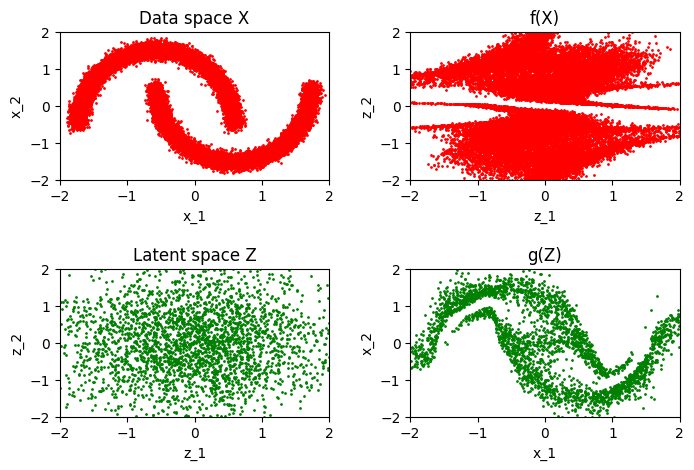

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.6970
Epoch 332/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7011
Epoch 333/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7035
Epoch 334/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7032
Epoch 335/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7000
Epoch 336/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7017
Epoch 337/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6920
Epoch 338/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7232
Epoch 339/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7109
Epoch 340/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6956
Epoch 341/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7032
Saved to ./output/generated_img_340.png


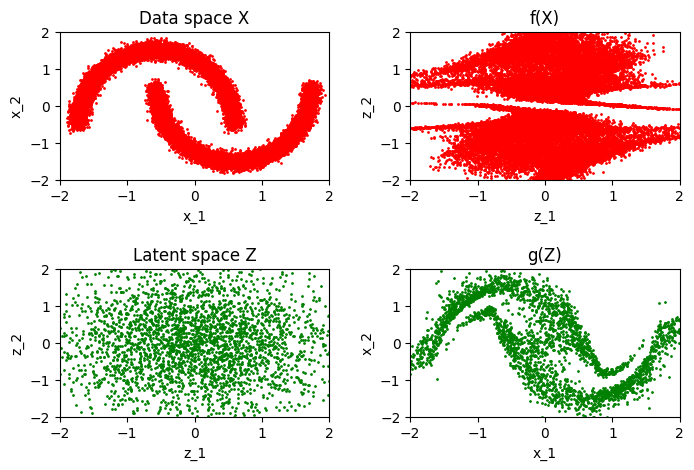

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7030
Epoch 342/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6875
Epoch 343/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7054
Epoch 344/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7039
Epoch 345/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7043
Epoch 346/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7026
Epoch 347/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6957
Epoch 348/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7072
Epoch 349/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6973
Epoch 350/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6982
Epoch 351/600
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7093
Saved to ./output/generated_img_350.png


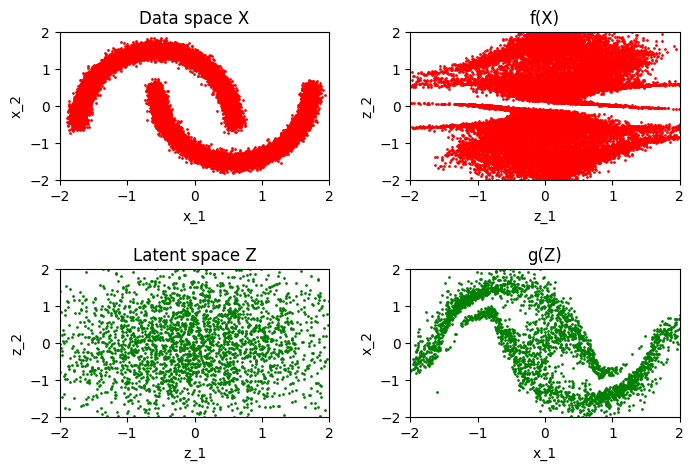

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.7089
Epoch 352/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6954
Epoch 353/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6922
Epoch 354/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7008
Epoch 355/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6975
Epoch 356/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6938
Epoch 357/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7055
Epoch 358/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6937
Epoch 359/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6917
Epoch 360/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7069
Epoch 361/600
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7005
Saved to ./output/generated_img_360.png


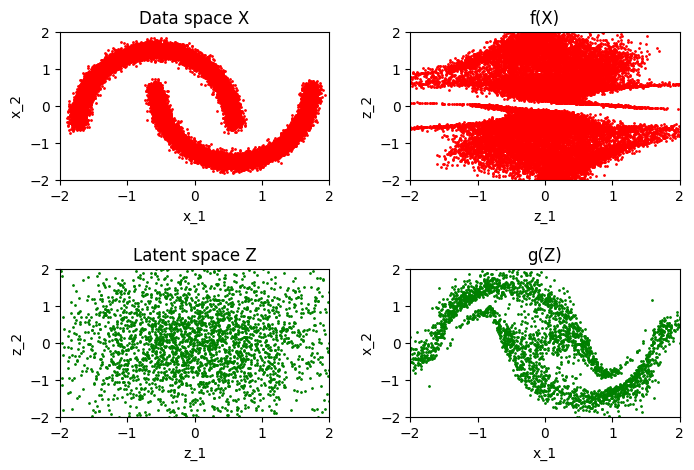

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.7005
Epoch 362/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6950
Epoch 363/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6969
Epoch 364/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6931
Epoch 365/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6883
Epoch 366/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6923
Epoch 367/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6915
Epoch 368/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7047
Epoch 369/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6977
Epoch 370/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6932
Epoch 371/600
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7015
Saved to ./output/generated_img_370.png


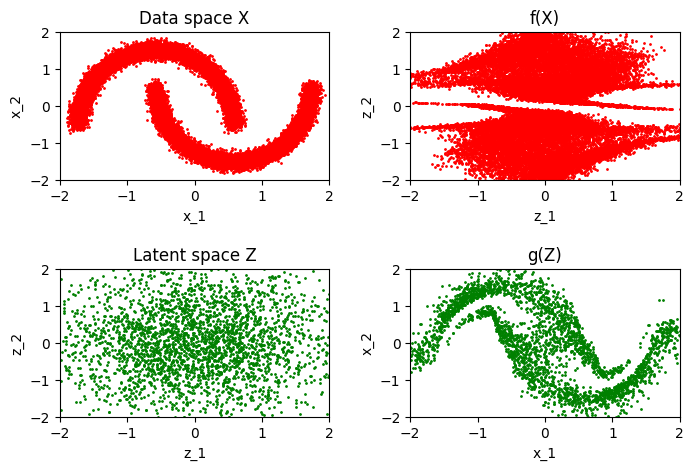

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.7015
Epoch 372/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7023
Epoch 373/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6930
Epoch 374/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6981
Epoch 375/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7256
Epoch 376/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6878
Epoch 377/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6970
Epoch 378/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6984
Epoch 379/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6976
Epoch 380/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7016
Epoch 381/600
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7037
Saved to ./output/generated_img_380.png


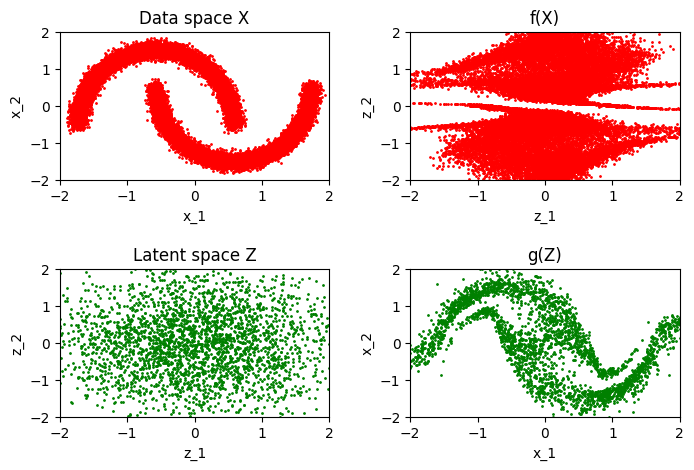

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7036
Epoch 382/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6935
Epoch 383/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7116
Epoch 384/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6831
Epoch 385/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6936
Epoch 386/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6999
Epoch 387/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6940
Epoch 388/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7018
Epoch 389/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6918
Epoch 390/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6915
Epoch 391/600
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6978
Saved to ./output/generated_img_390.png


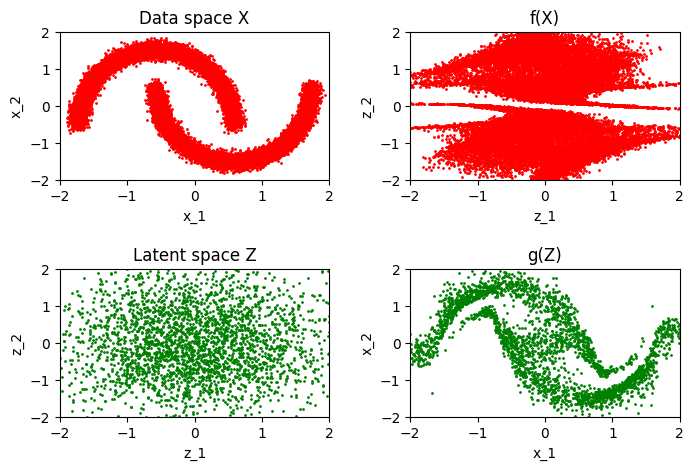

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.6977
Epoch 392/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7035
Epoch 393/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7008
Epoch 394/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6933
Epoch 395/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7005
Epoch 396/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6942
Epoch 397/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6872
Epoch 398/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6945
Epoch 399/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7005
Epoch 400/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6952
Epoch 401/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7031
Saved to ./output/generated_img_400.png


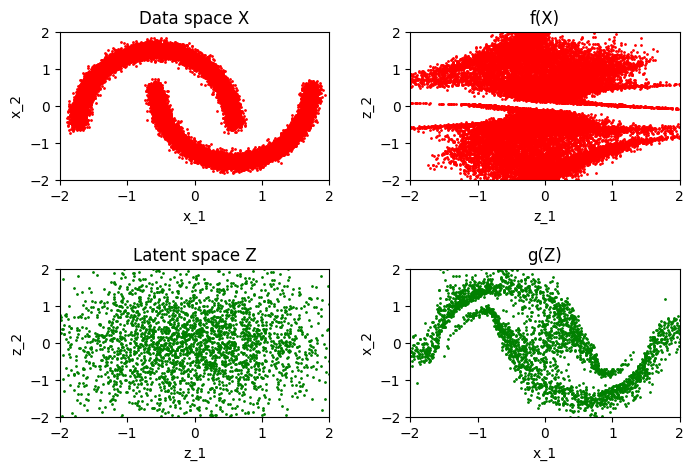

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.7031
Epoch 402/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6871
Epoch 403/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7026
Epoch 404/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6983
Epoch 405/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7016
Epoch 406/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6941
Epoch 407/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7026
Epoch 408/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6973
Epoch 409/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7065
Epoch 410/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6945
Epoch 411/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6970
Saved to ./output/generated_img_410.png


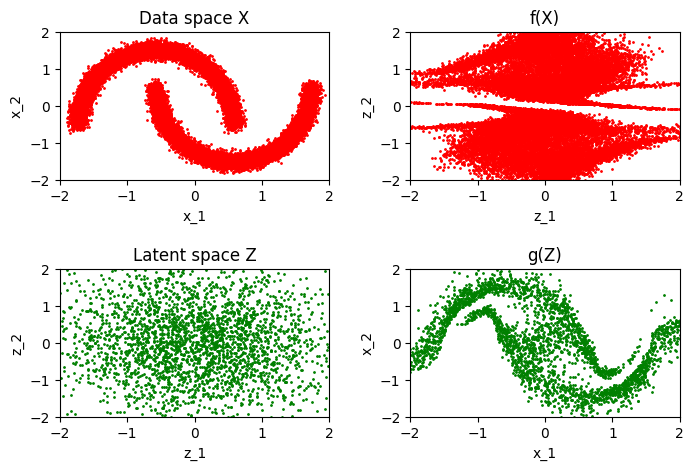

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.6970
Epoch 412/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6988
Epoch 413/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6940
Epoch 414/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6896
Epoch 415/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6988
Epoch 416/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6918
Epoch 417/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6891
Epoch 418/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6926
Epoch 419/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6985
Epoch 420/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6957
Epoch 421/600
113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7010
Saved to ./output/generated_img_420.png


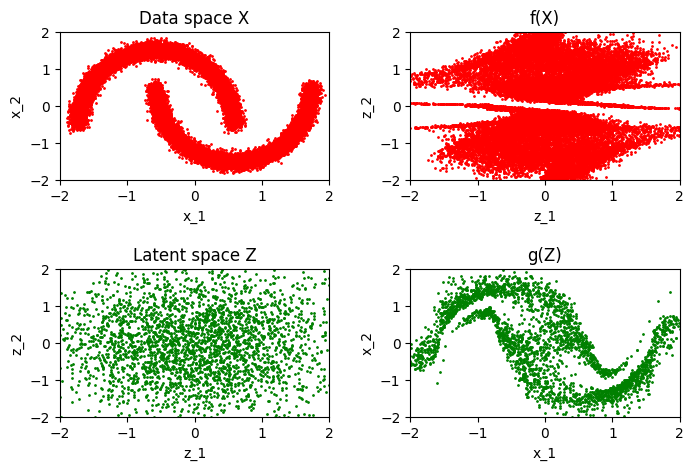

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.7008
Epoch 422/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7020
Epoch 423/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6985
Epoch 424/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6861
Epoch 425/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7052
Epoch 426/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6891
Epoch 427/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6989
Epoch 428/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6974
Epoch 429/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6926
Epoch 430/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6932
Epoch 431/600
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6991
Saved to ./output/generated_img_430.png


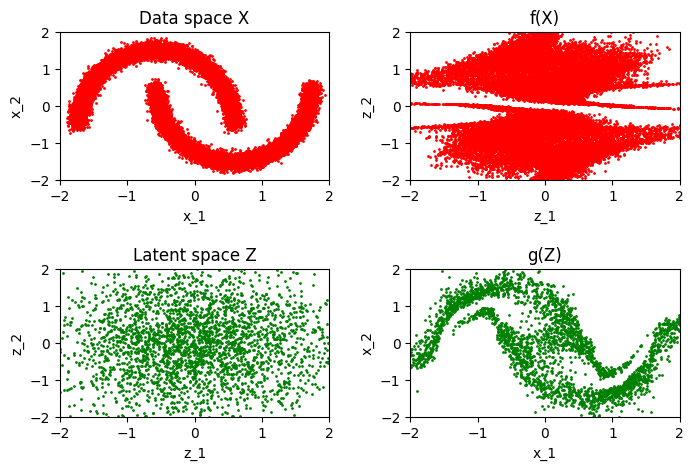

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.6988
Epoch 432/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7103
Epoch 433/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7035
Epoch 434/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6974
Epoch 435/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6945
Epoch 436/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6962
Epoch 437/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6960
Epoch 438/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7001
Epoch 439/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6978
Epoch 440/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6913
Epoch 441/600
113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7052
Saved to ./output/generated_img_440.png


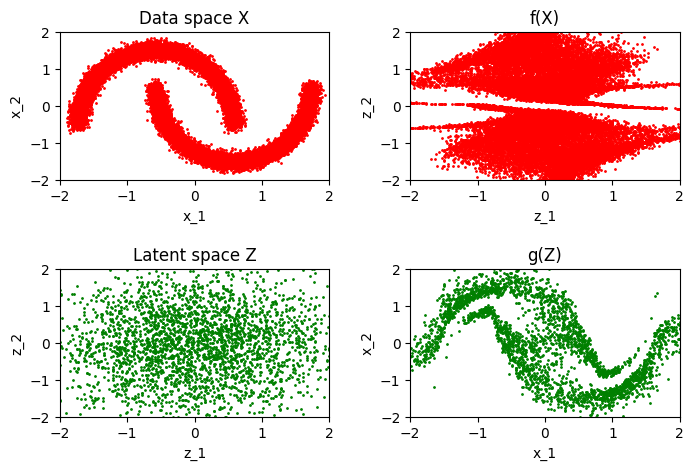

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7050
Epoch 442/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.6903
Epoch 443/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7029
Epoch 444/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6948
Epoch 445/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7041
Epoch 446/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7061
Epoch 447/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6906
Epoch 448/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6979
Epoch 449/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6992
Epoch 450/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6962
Epoch 451/600
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6962
Saved to ./output/generated_img_450.png


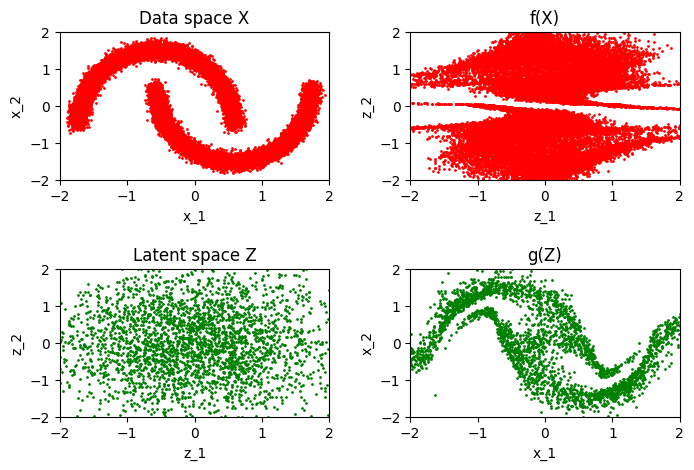

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.6961
Epoch 452/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6899
Epoch 453/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6943
Epoch 454/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6953
Epoch 455/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6927
Epoch 456/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6952
Epoch 457/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6981
Epoch 458/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6953
Epoch 459/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7107
Epoch 460/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6966
Epoch 461/600
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7103
Saved to ./output/generated_img_460.png


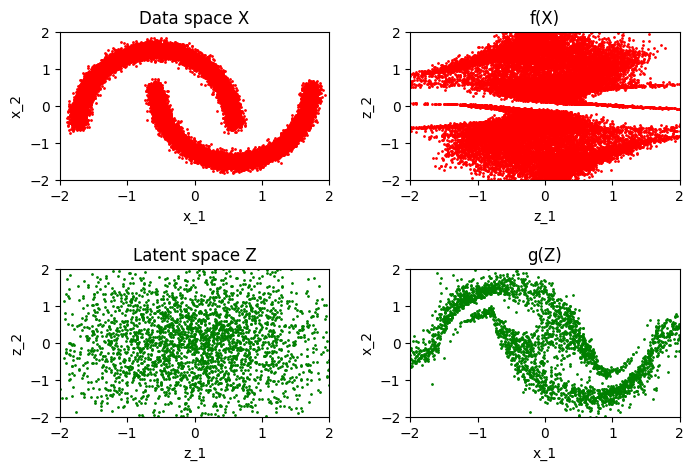

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7098
Epoch 462/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6981
Epoch 463/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7138
Epoch 464/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6892
Epoch 465/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6897
Epoch 466/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6975
Epoch 467/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6999
Epoch 468/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7031
Epoch 469/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6971
Epoch 470/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7070
Epoch 471/600
113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6948
Saved to ./output/generated_img_470.png


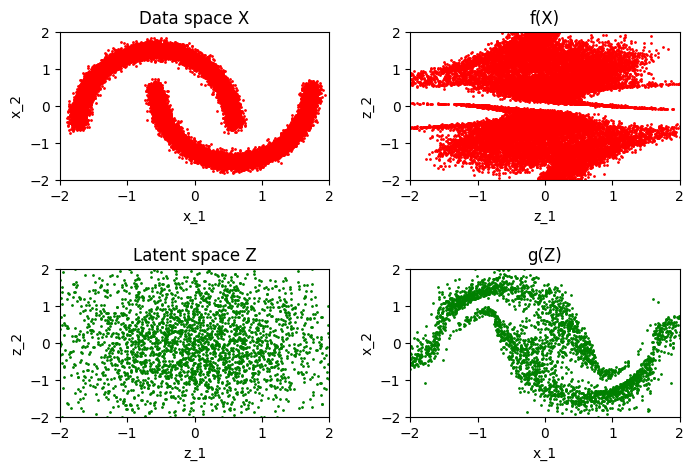

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.6949
Epoch 472/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7021
Epoch 473/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6963
Epoch 474/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6913
Epoch 475/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6902
Epoch 476/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6975
Epoch 477/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6970
Epoch 478/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7017
Epoch 479/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7009
Epoch 480/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7046
Epoch 481/600
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6975
Saved to ./output/generated_img_480.png


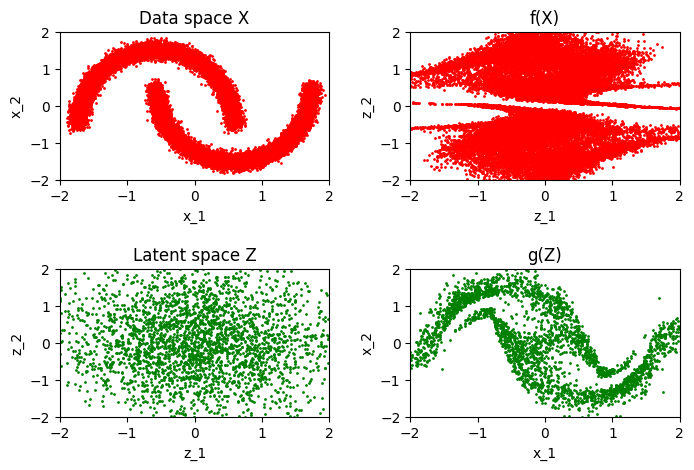

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.6973
Epoch 482/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7081
Epoch 483/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6910
Epoch 484/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6851
Epoch 485/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6933
Epoch 486/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6989
Epoch 487/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6907
Epoch 488/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6970
Epoch 489/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7012
Epoch 490/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6901
Epoch 491/600
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6999
Saved to ./output/generated_img_490.png


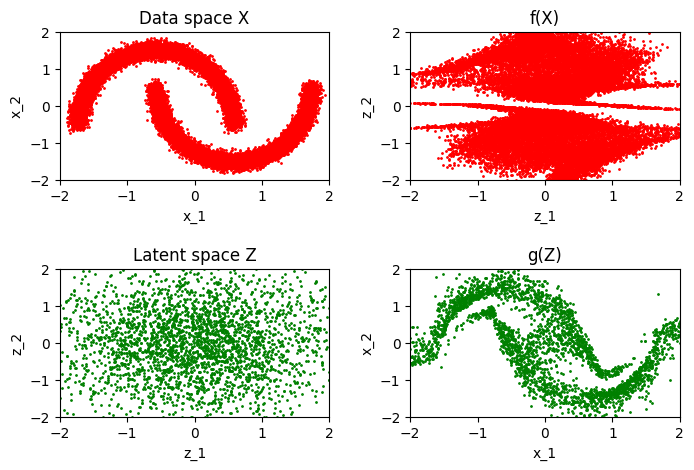

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.6999
Epoch 492/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7007
Epoch 493/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6903
Epoch 494/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6957
Epoch 495/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6986
Epoch 496/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6932
Epoch 497/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7004
Epoch 498/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7065
Epoch 499/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6942
Epoch 500/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6884
Epoch 501/600
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6928
Saved to ./output/generated_img_500.png


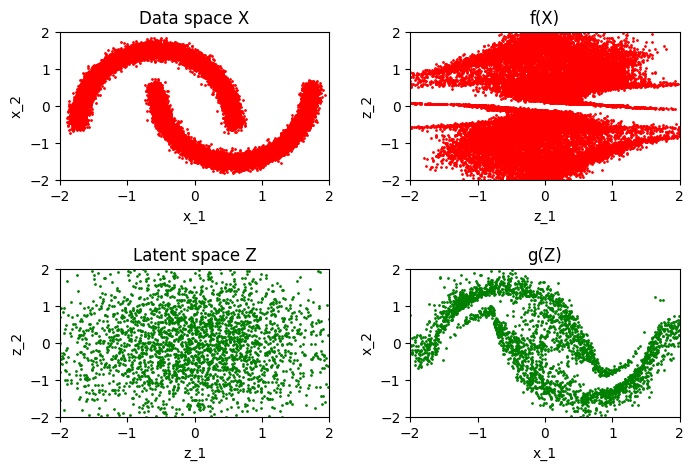

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.6928
Epoch 502/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7000
Epoch 503/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6982
Epoch 504/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6968
Epoch 505/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6878
Epoch 506/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6962
Epoch 507/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6935
Epoch 508/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6996
Epoch 509/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6938
Epoch 510/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6969
Epoch 511/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6981
Saved to ./output/generated_img_510.png


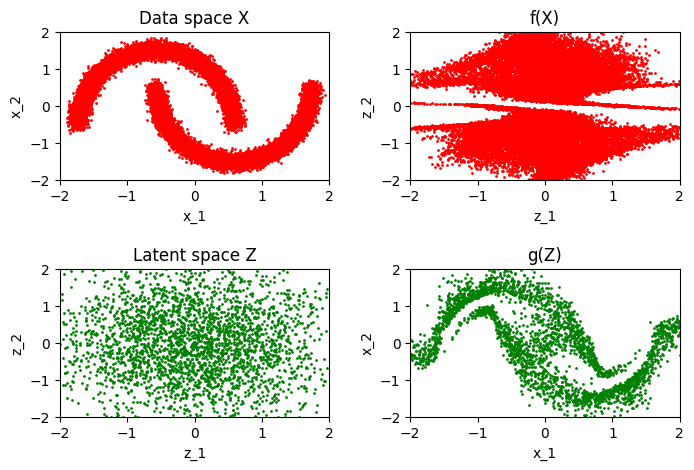

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.6980
Epoch 512/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.7003
Epoch 513/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6980
Epoch 514/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6909
Epoch 515/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7024
Epoch 516/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6998
Epoch 517/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6942
Epoch 518/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7017
Epoch 519/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6908
Epoch 520/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6949
Epoch 521/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7015
Saved to ./output/generated_img_520.png


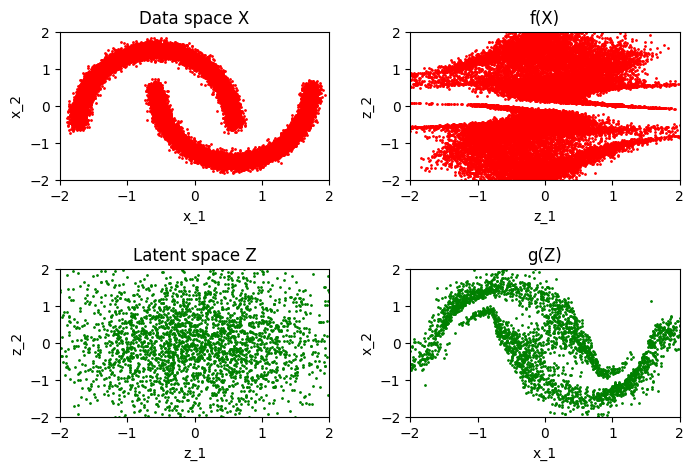

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.7014
Epoch 522/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6971
Epoch 523/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6942
Epoch 524/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7004
Epoch 525/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6950
Epoch 526/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6969
Epoch 527/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6989
Epoch 528/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6893
Epoch 529/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6883
Epoch 530/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7132
Epoch 531/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6972
Saved to ./output/generated_img_530.png


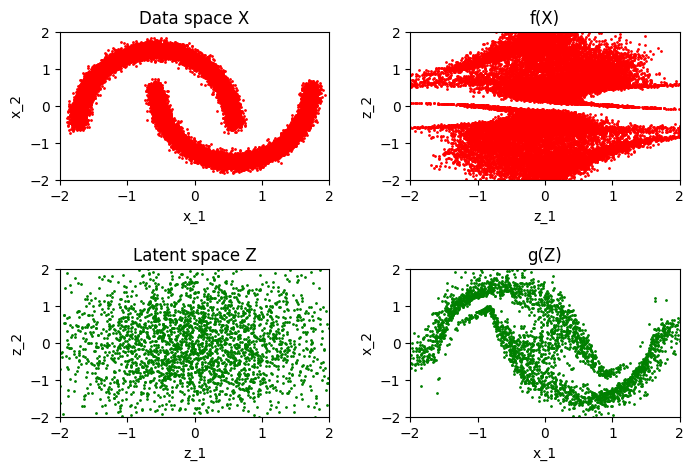

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.6972
Epoch 532/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6995
Epoch 533/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6975
Epoch 534/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6947
Epoch 535/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6952
Epoch 536/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7115
Epoch 537/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6968
Epoch 538/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6944
Epoch 539/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7015
Epoch 540/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6941
Epoch 541/600
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6922
Saved to ./output/generated_img_540.png


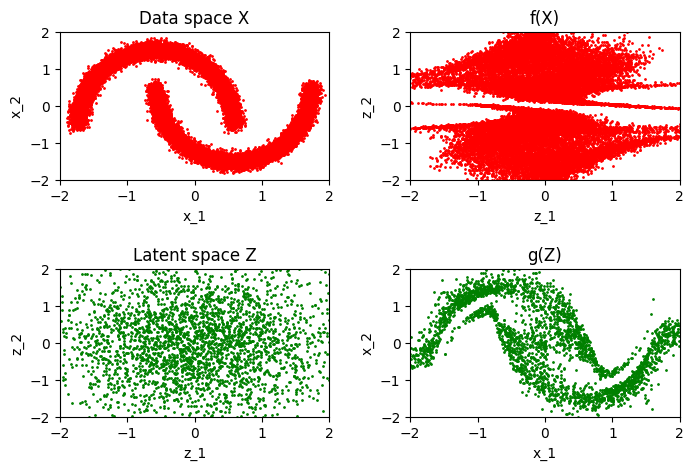

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.6922
Epoch 542/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6891
Epoch 543/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6911
Epoch 544/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6951
Epoch 545/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7132
Epoch 546/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6871
Epoch 547/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7114
Epoch 548/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6923
Epoch 549/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6861
Epoch 550/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6939
Epoch 551/600
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7091
Saved to ./output/generated_img_550.png


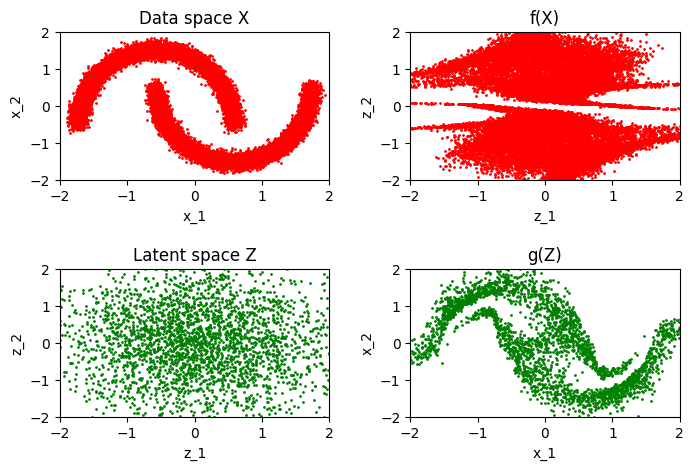

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7088
Epoch 552/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6970
Epoch 553/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7009
Epoch 554/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6881
Epoch 555/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6964
Epoch 556/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6884
Epoch 557/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6964
Epoch 558/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7130
Epoch 559/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6871
Epoch 560/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7005
Epoch 561/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6953
Saved to ./output/generated_img_560.png


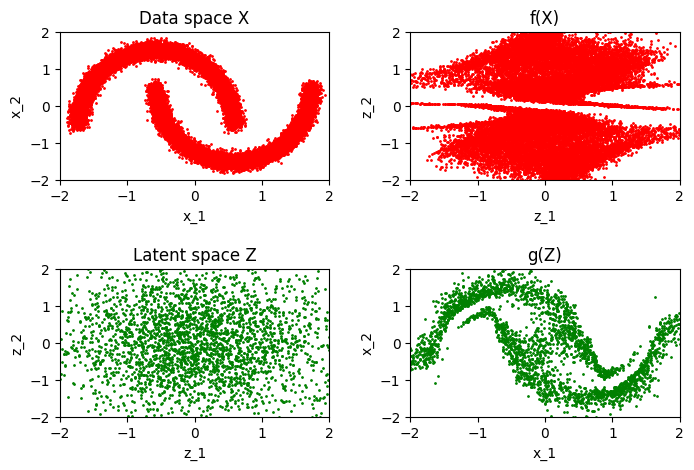

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.6953
Epoch 562/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6912
Epoch 563/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6925
Epoch 564/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6945
Epoch 565/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6924
Epoch 566/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6916
Epoch 567/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6900
Epoch 568/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7027
Epoch 569/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6888
Epoch 570/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6993
Epoch 571/600
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6993
Saved to ./output/generated_img_570.png


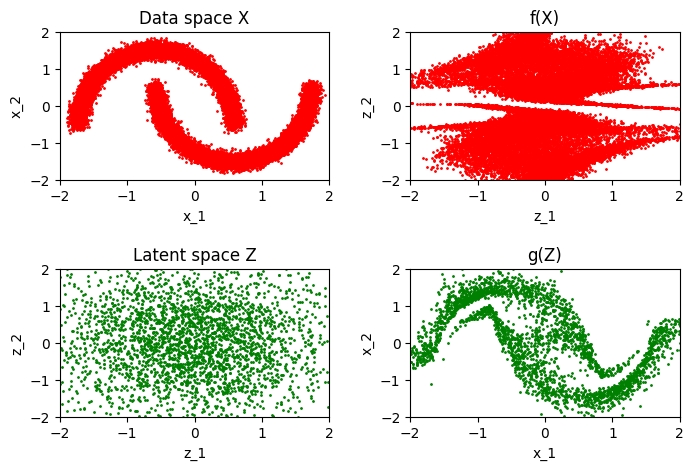

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.6995
Epoch 572/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6920
Epoch 573/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6988
Epoch 574/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7010
Epoch 575/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6951
Epoch 576/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6862
Epoch 577/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6950
Epoch 578/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6945
Epoch 579/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6922
Epoch 580/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6974
Epoch 581/600
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7042
Saved to ./output/generated_img_580.png


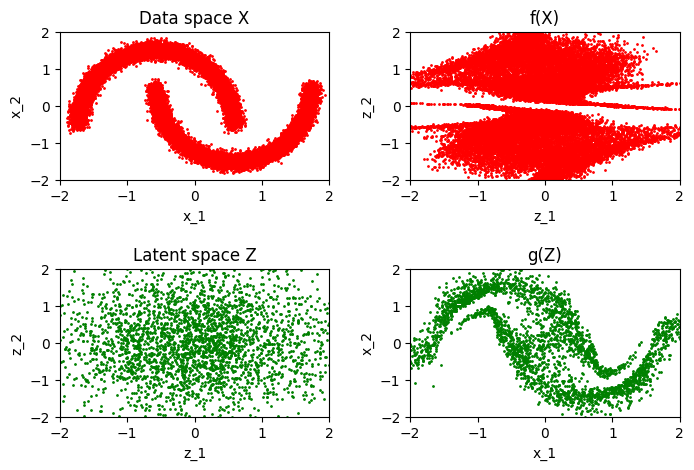

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.7041
Epoch 582/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6931
Epoch 583/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6964
Epoch 584/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7056
Epoch 585/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6937
Epoch 586/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6937
Epoch 587/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7015
Epoch 588/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7033
Epoch 589/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6856
Epoch 590/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6926
Epoch 591/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6897
Saved to ./output/generated_img_590.png


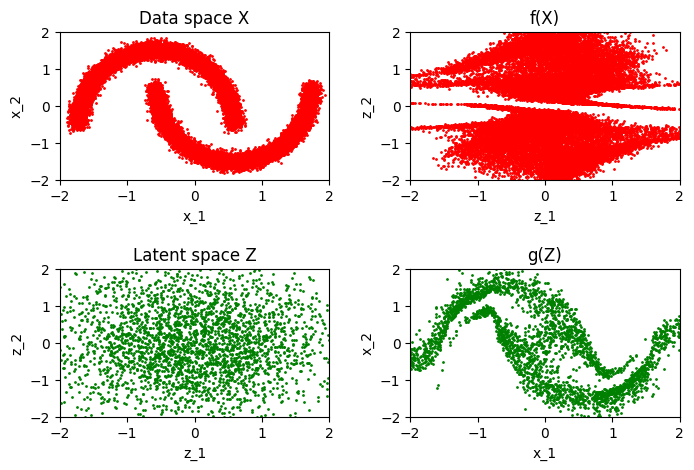

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.6897
Epoch 592/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6968
Epoch 593/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6919
Epoch 594/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7002
Epoch 595/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6974
Epoch 596/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6940
Epoch 597/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6946
Epoch 598/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6856
Epoch 599/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6923
Epoch 600/600
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6940


In [9]:
history = model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

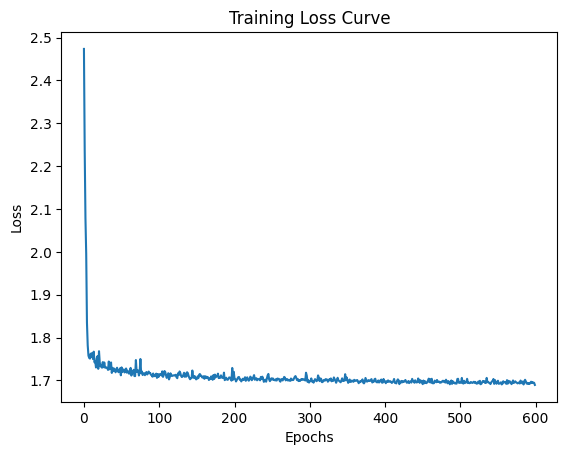

In [10]:
# Plot training loss curve
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

## Generate images

In [11]:
x, z, samples = img_generator_callback.generate()

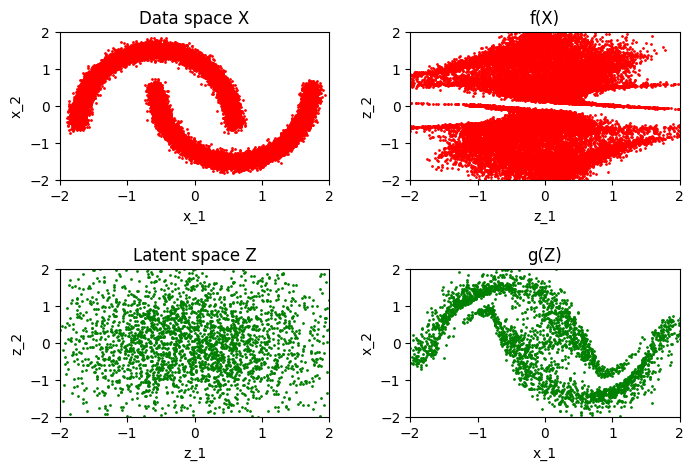

In [12]:
img_generator_callback.display(x, z, samples)